# Model Building, Training and Deployment

In [12]:
import pandas as pd
import numpy as np
import sagemaker_datawrangler
import matplotlib.pyplot as plt

## Load the processed data 

In [13]:
# Download Parquet from S3 locally, or use awswrangler to read pandas df directly from S3
processed_dataset = "s3://fcc-spark-example/subset-boston-data.parquet/"

In [14]:
comp_pd_df = pd.read_parquet(processed_dataset)

In [15]:
comp_pd_df

       no2_avg        date  temp_max  temp_min  wind_avg  pressure_sea_level  \
0     0.015557  2020-01-07     41.35     30.60      4.30             1015.00   
1     0.011425  2020-01-08     44.25     33.35      4.65             1009.45   
2     0.005458  2020-01-09     40.40     22.10      7.45             1029.80   
3     0.016883  2020-01-10     51.00     24.90      5.30             1034.60   
4     0.006466  2020-01-11     67.85     49.25      7.25             1023.60   
...        ...         ...       ...       ...       ...                 ...   
1230  0.004851  2023-06-08     65.55     55.85      6.10             1004.35   
1231  0.008181  2023-06-09     63.75     54.25      4.80             1006.30   
1232  0.007668  2023-06-10     65.20     53.70      4.20             1006.90   
1233  0.004565  2023-06-11     74.85     56.70      6.30             1011.25   
1234  0.005963  2023-06-12     80.10     66.00      8.00             1011.80   

      pressure_station  
0             

## Spliting the data for training and testing 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

comp_pd_df = comp_pd_df.set_index('date')
comp_pd_df.index.name = None

# Drop the 1st row 
aq_df = comp_pd_df.iloc[1:].copy()
aq_df.index = pd.to_datetime(aq_df.index)

# Dropping the NaN 
aq_df = aq_df.dropna()

# Use the data from years 2020 up to 2022 as training, and the year 2023 as our candidate year for testing and validating our model.
aq_train_df = aq_df[aq_df.index.year < 2023]
aq_test_df = aq_df[aq_df.index.year == 2023]

# Input Feature 
x_train = aq_train_df.drop('no2_avg',axis=1)
x_test = aq_test_df.drop('no2_avg',axis=1)

# Class Labels 
y_train = aq_train_df[["no2_avg"]]
y_test = aq_test_df[["no2_avg"]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train.head())

(1071, 5) (1071, 1)
(163, 5) (163, 1)
            temp_max  temp_min  wind_avg  pressure_sea_level  pressure_station
2020-01-08     44.25     33.35      4.65             1009.45            504.45
2020-01-09     40.40     22.10      7.45             1029.80            514.60
2020-01-10     51.00     24.90      5.30             1034.60            517.05
2020-01-11     67.85     49.25      7.25             1023.60            511.60
2020-01-12     71.95     51.25      9.85             1012.05            505.60


## Few helper functions

In [18]:
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# sMAPE is used in KDD Air Quality challenge: https://biendata.com/competition/kdd_2018/evaluation/ 
def smape(actual, predicted):
    dividend= np.abs(np.array(actual) - np.array(predicted))
    denominator = np.array(actual) + np.array(predicted)
    
    return 2 * np.mean(np.divide(dividend, denominator, out=np.zeros_like(dividend), where=denominator!=0, casting='unsafe'))

def print_metrics(y_test, y_pred):
    print("RMSE: %.4f" % sqrt(mean_squared_error(y_test, y_pred)))
    print('Variance score: %.4f' % r2_score(y_test, y_pred))
    print('Explained variance score: %.4f' % explained_variance_score(y_test, y_pred))
    forecast_err = np.array(y_test) - np.array(y_pred)
    print('Forecast bias: %.4f' % (np.sum(forecast_err) * 1.0/len(y_pred) ))
    print('sMAPE: %.4f' % smape(y_test, y_pred))

## Training the model 

In the section below, we create a new training job using the Linear Learner algorithm. Once that job completes, we deploy an endpoint and run some validation tests against it. 

**NOTE**: You only need to create this training job and deploy it once. You can use the same endpoint, even in future runs of this notebook, without re-training or re-deploying. 

In [19]:
import boto3
from sagemaker import get_execution_role, LinearLearner

# Setting the bucket name
bucket = 'fcc-spark-example'
data_location = f's3://{bucket}/aq-linearlearner/data/train'
output_location = f's3://{bucket}/aq-linearlearner/output'


# This is used to run the LinearLearner training job
role = get_execution_role()

llearner = LinearLearner(role=role,
                predictor_type='regressor',
                normalize_data=True,
                normalize_label=True,
                instance_count=1,
                use_spot_instances = True,
                max_run= 1800,
                max_wait = 3600,
                instance_type='ml.c5.xlarge',
                output_path=output_location,
                data_location=data_location)

# Starting the training 
llearner.fit([
    llearner.record_set(x_train.values.astype('float32'), y_train.values[:, 0].astype('float32'), channel='train'),
    llearner.record_set(x_test.values.astype('float32'), y_test.values[:, 0].astype('float32'), channel='test')
])

2023-06-14 20:45:23 Starting - Starting the training job...
2023-06-14 20:45:37 Starting - Preparing the instances for training...
2023-06-14 20:46:31 Downloading - Downloading input data...
2023-06-14 20:46:57 Training - Downloading the training image......
2023-06-14 20:47:52 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[06/14/2023 20:47:59 INFO 140522871928640] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'aut

## Deploying the model (`endpoint`)

In [20]:
llearner_predictor = llearner.deploy(initial_instance_count=1,
                                 instance_type='ml.t2.medium')

----------------------!

In [21]:
result = llearner_predictor.predict(x_test.values.astype('float32'))
y_sm_pred = [r.label["score"].float32_tensor.values[0] for r in result]
y_sm_test = y_test.values[:, 0].astype('float32')
print_metrics(y_sm_test, y_sm_pred)

RMSE: 0.0027
Variance score: 0.3825
Explained variance score: 0.3828
Forecast bias: 0.0001
sMAPE: 0.2961


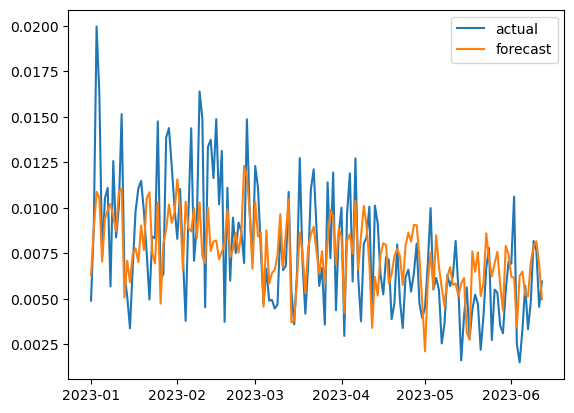

In [25]:
y_sm_pred_df = pd.DataFrame(y_sm_pred, columns=y_train.columns).set_index(y_test.index).sort_index()
y_sm_test_df = pd.DataFrame(y_sm_test, columns=y_train.columns).set_index(y_test.index).sort_index()

plt.plot(y_sm_test_df, label='actual')
plt.plot(y_sm_pred_df, label='forecast')
plt.legend()
plt.show()

In [23]:
endpoint_name = llearner_predictor.endpoint_name
print(endpoint_name)

linear-learner-2023-06-14-20-50-14-157


# Clean up

In [ ]:
## Delete the endpoint 

## llearner_predictor.delete_endpoint()